In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import os
import toolz
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import datetime

from glob import glob

import pandas as pd
from tqdm.notebook import tqdm

try:
    dir_changed
except:
    os.chdir('..')
    dir_changed = True

import config as cfg
import src.utils as utils

from src.loaders import CSVLoader
from src.models import LGBM

In [8]:
from src.add_features import CorrelationFinder, FeatureManager, VarianceCalculator, OutlierFinder

In [9]:
loader=CSVLoader()

In [10]:
machines = pd.unique(loader.all_months["machine_id"]).tolist()
machine_id =machines[7]

In [11]:
fm = FeatureManager(machine_id=machine_id)

/home/michal/anaconda3/envs/kghm/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [12]:
selected_lk_variables = ['BREAKP', 'ENGCOOLT', 'ENGOILP', 'ENGOILT',
       'ENGRPM', 'ERROR', 'FUELUS', 'GROILP', 'GROILT', 'HYDOILP', 'HYDOILT',
       'INTAKEP', 'INTAKET', 'SELGEAR', 'SPEED', 'SWITCHMOVE' , *[ent for ent in sorted(fm.loader.engineered_data.columns if fm.loader.engineered_data is not None else [])]]

selected_wos_variables = ['BREAKP', 'ENGCOOLT', 'ENGOILP', 'ENGRPM', 'ENGTPS',
       'ERROR', 'FUELUS', 'GROILP', 'GROILT', 'HYDOILP', 'HYDOILT', 'INTAKEP',
       'INTAKET', 'SELGEAR', 'SPEED', 'TEMPIN', 'TRNAUT', 'TRNBPS', 'TRNLUP', *[ent for ent in sorted(fm.loader.engineered_data.columns if fm.loader.engineered_data is not None else [])]]

In [13]:
grouping_freq = "1min"
window_size = 20

In [14]:
machine_data = fm.loader.get_all_data()

In [15]:
# data = machine_data["middle"]

# data = data[["czas", *selected_wos_variables]]
# data = utils.get_time_grouped_data(data, freq=grouping_freq)
# data = data.reset_index()
# data["calculate"] = [(x%20 == 0) for x in range(0,len(data))]

In [29]:
if machine_id[:2] == "LK":
    selected_columns = selected_lk_variables
else:
    selected_columns = selected_wos_variables

In [30]:
def prepare_dataset(data, window_size, grouping_freq, selected_columns):
    data = data[["czas", *selected_wos_variables]]
    data = utils.get_time_grouped_data(data, freq=grouping_freq)
    data = data.reset_index()
    data["calculate"] = [(x%20 == 0) for x in range(0,len(data))]
    dataset = []
    tmp_var = list(range(-window_size + 1,1))
    for idx in tqdm(data.index):
        if (
            idx > window_size
            and data.loc[idx, "calculate"]
            and (
                (data.loc[idx, "czas"] - data.loc[idx - window_size, "czas"])
                == pd.Timedelta(grouping_freq) * window_size
            )
        ):
            tmp = data.loc[(idx-window_size + 1):idx, :].drop(columns=["czas","calculate"]).fillna(method="bfill").fillna(0)
            tmp["idx"] = 1
            tmp["index"] = tmp_var
            tmp = tmp.pivot(index="idx", columns="index")
            tmp.columns = ['_'.join([str(col_lv) for col_lv in col]) for col in tmp.columns.values]
            dataset.append(tmp)
    return pd.concat(dataset)

In [31]:
false_data = prepare_dataset(machine_data["middle"], window_size, grouping_freq, selected_columns)
false_labels = np.zeros(len(false_data))

  0%|          | 0/131040 [00:00<?, ?it/s]

In [32]:
fault_data = machine_data["last"]
fault_data= fault_data[fault_data["czas"] > (fault_data.tail(1)["czas"] - pd.Timedelta('4W')).values[0]]
true_data = prepare_dataset(fault_data, window_size, grouping_freq, selected_columns)
true_labels = np.ones(len(true_data))

  0%|          | 0/40073 [00:00<?, ?it/s]

In [33]:
true_data

BREAKP_-19   BREAKP_-18   BREAKP_-17   BREAKP_-16   BREAKP_-15  \
idx                                                                    
1       0.000000     0.000000     0.000000     0.000000     0.000000   
1       0.000000     0.000000     0.000000     0.000000     0.000000   
1       0.000000     0.000000     0.000000     0.000000     0.000000   
1       0.000000     0.000000     0.000000     0.000000     0.000000   
1       0.000000     0.000000     0.000000     0.000000     0.000000   
..           ...          ...          ...          ...          ...   
1       0.000000     0.000000     0.000000     0.000000     0.000000   
1       0.000000     0.000000     0.000000     0.000000     0.000000   
1       0.000000     0.000000     0.000000     0.000000     0.000000   
1       0.000000     0.000000     0.000000     0.000000     0.000000   
1    9755.555556  9755.555556  9755.555556  9755.555556  9755.555556   

      BREAKP_-14   BREAKP_-13   BREAKP_-12   BREAKP_-11   BREAKP_-10  ...  \
idx                                                                   ...   
1       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
1       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
1       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
1       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
1       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
..           ...          ...          ...          ...          ...  ...   
1       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
1       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
1       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
1       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
1    9755.555556  9755.555556  9755.555556  9755.555556  9755.555556  ...   

     TRNLUP_-9  TRNLUP_-8  TRNLUP_-7  TRNLUP_-6  TRNLUP_-5  TRNLUP_-4  \
idx                                                                     
1          0.0        0.0        0.0        0.0        0.0        0.0   
1          0.0        0.0        0.0        0.0        0.0        0.0   
1          0.0        0.0        0.0        0.0        0.0        0.0   
1          0.0        0.0        0.0        0.0        0.0        0.0   
1          0.0        0.0        0.0        0.0        0.0        0.0   
..         ...        ...        ...        ...        ...        ...   
1          0.0        0.0        0.0        0.0        0.0        0.0   
1          0.0        0.0        0.0        0.0        0.0        0.0   
1          0.0        0.0        0.0        0.0        0.0        0.0   
1          0.0        0.0        0.0        0.0        0.0        0.0   
1          0.0        0.0        0.0        0.0        0.0        0.0   

     TRNLUP_-3  TRNLUP_-2  TRNLUP_-1  TRNLUP_0  
idx                                             
1          0.0        0.0        0.0       0.0  
1          0.0        0.0        0.0       0.0  
1          0.0        0.0        0.0       0.0  
1          0.0        0.0        0.0       0.0  
1          0.0        0.0        0.0       0.0  
..         ...        ...        ...       ...  
1          0.0        0.0        0.0       0.0  
1          0.0        0.0        0.0       0.0  
1          0.0        0.0        0.0       0.0  
1          0.0        0.0        0.0       0.0  
1          0.0        0.0        0.0       0.0  

[2002 rows x 380 columns]

In [36]:
all_data = pd.concat([true_data, false_data])
all_labels = np.concatenate((true_labels, false_labels))

In [37]:
all_labels.shape

(8552,)

In [38]:
all_data.shape

(8552, 380)

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_val, y_train, y_val = train_test_split(all_data, all_labels, test_size=0.2)

In [41]:
model = LGBM()

In [42]:
best_params = model.find_best_params(X_train, y_train, X_val, y_val)

In [43]:
model.train(X_train, y_train, best_params)

In [44]:
preds = model.predict(X_val)

In [48]:
sum(y_val)/len(y_val)

0.23670368205727646

In [45]:
(preds == y_val).mean()

0.6288720046756283

In [125]:
model.trained_model.feature_importances_

array([ 3, 13,  0, ...,  0,  0,  0], dtype=int32)

In [46]:
import lightgbm

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

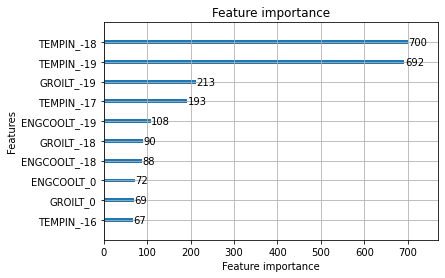

In [47]:
lightgbm.plot_importance(model.trained_model, max_num_features=10)